In [1]:
! pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.6 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input,GlobalAvgPool2D )
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Data Management

## Download Data

In [3]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d jangedoo/utkface-new
! kaggle datasets download -d janwidziski/face-obstructions
! unzip "/content/utkface-new.zip" -d "/content/dataset"
! unzip "/content/face-obstructions.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/data/none/i14167.jpg  
  inflating: /content/dataset/data/none/i14168.jpg  
  inflating: /content/dataset/data/none/i14169.jpg  
  inflating: /content/dataset/data/none/i14170.jpg  
  inflating: /content/dataset/data/none/i14171.jpg  
  inflating: /content/dataset/data/none/i14172.jpg  
  inflating: /content/dataset/data/none/i14173.jpg  
  inflating: /content/dataset/data/none/i14174.jpg  
  inflating: /content/dataset/data/none/i14175.jpg  
  inflating: /content/dataset/data/none/i14176.jpg  
  inflating: /content/dataset/data/none/i14177.jpg  
  inflating: /content/dataset/data/none/i14178.jpg  
  inflating: /content/dataset/data/none/i14179.jpg  
  inflating: /content/dataset/data/none/i14180.jpg  
  inflating: /content/dataset/data/none/i14181.jpg  
  inflating: /content/dataset/data/none/i14182.jpg  
  inflating: /content/dataset/data/none/i14183.jpg  
  inflating: /content/dataset/data/none/i14184.j

## Prepare data

In [4]:
batch_size = 64
img_shape = (64,64,3)
learning_rate = 2e-4

In [5]:
import shutil
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [6]:
os.mkdir('/content/dataset/dataset')
classes = os.listdir('/content/dataset/data')
classes = [cls for cls in classes if cls not in ['none']]
data_path = "/content/dataset/data"
for cls in classes:
  for file in os.listdir(os.path.join(data_path, cls)):
    shutil.move(os.path.join(data_path, cls, file), "/content/dataset/dataset")

In [7]:
obstruction_path = "/content/dataset/dataset"
ds_masked = image_dataset_from_directory(obstruction_path,
                                         label_mode = None,
                                         image_size = (img_shape[0], img_shape[1]),
                                         batch_size = batch_size)

Found 10608 files belonging to 1 classes.


In [8]:
unmasked_path = "/content/dataset/UTKFace"
ds_unmasked = image_dataset_from_directory(unmasked_path,
                                          label_mode = None,
                                          image_size = (img_shape[0], img_shape[1]),
                                          batch_size = batch_size)

Found 23708 files belonging to 1 classes.


In [9]:
ds_unmasked = ds_unmasked.take(10000)
ds_masked = ds_masked.take(300)

In [10]:
def preprocess(image):
  return tf.cast(image,tf.float32)/127.5 - 1.0

In [11]:
train_masked_dataset = (ds_masked
                        .map(preprocess)
                        .unbatch()
                        .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
                        .batch(batch_size, drop_remainder=True)
                        .prefetch(tf.data.AUTOTUNE))

In [12]:
test_masked_dataset = (ds_masked
                      .map(preprocess)
                      .unbatch()
                      .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
                      .batch(batch_size, drop_remainder=True)
                      .prefetch(tf.data.AUTOTUNE))

In [13]:
train_unmasked_dataset = (ds_unmasked
                          .map(preprocess)
                          .unbatch()
                          .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
                          .batch(batch_size, drop_remainder=True)
                          .prefetch(tf.data.AUTOTUNE))

In [14]:
train_dataset = tf.data.Dataset.zip((train_masked_dataset, train_unmasked_dataset))

In [15]:
for d in train_dataset.take(1):
  d_masked, d_unmasked = d
  print(d_masked.shape, d_unmasked.shape)

(64, 64, 64, 3) (64, 64, 64, 3)


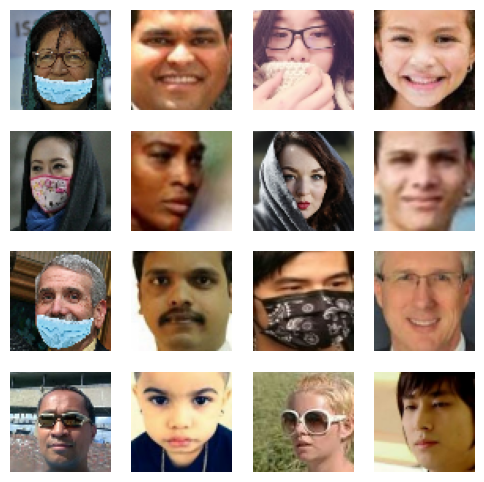

In [16]:
plt.figure(figsize = (6,6))
k = 0
n = 16
for i in range(n):
  ax = plt.subplot(4, 4, k+1)
  if i%2==0:
    plt.imshow((d_masked[i]+1)/2)
  if i%2!=0:
    plt.imshow((d_unmasked[i]+1)/2)

  plt.axis("off")
  k+=1

# Modeling

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal

In [18]:
def downsample(filters,kernel_size,apply_instance_norm=True,n_strides=2):
  model = Sequential()
  model.add(Conv2D(filters, kernel_size, strides=n_strides, padding='same',
             kernel_initializer = RandomNormal(0.,0.02), use_bias=False))
  if apply_instance_norm:
    model.add(tfa.layers.InstanceNormalization())
  model.add(LeakyReLU(0.2))

  return model

In [19]:
def upsample(filters,kernel_size):

  model=tf.keras.Sequential([
      Conv2DTranspose(filters, kernel_size, strides=2, padding='same',
                      kernel_initializer = RandomNormal(0.,0.02), use_bias=False),
      tfa.layers.InstanceNormalization(),
      LeakyReLU(0.2),
  ])
  return model

In [20]:
def generator():
  input = Input((img_shape[0], img_shape[1], 3))
  x = input
  store = []
  for filter in [32, 64, 128, 256, 512]:
    x = downsample(filter, 4)(x)
    store.append(x)

  for filter in [512,256,128,64,32]:
    x = tf.concat([x,store.pop()],axis=-1)
    x = upsample(filter,4)(x)

  output = Conv2DTranspose(3, 4, strides=1, padding='same',
                     kernel_initializer = RandomNormal(0.,0.02), activation='tanh')(x)

  model = Model(input, output, name='unet_generator')
  return model

In [21]:
generator().summary()

Model: "unet_generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 32)           1600      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 16, 16, 64)           32896     ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 8, 8, 128)            131328    ['sequential_1[0][0]']        
                                                                                     

In [22]:
def discriminator():
  input = Input((img_shape[0], img_shape[1], 3))
  x = input

  x = downsample(32, 4, apply_instance_norm = False)(x)
  x = downsample(64, 4, apply_instance_norm = True)(x)
  x = downsample(128, 4, apply_instance_norm = True)(x)
  x = downsample(256, 4, apply_instance_norm = True,)(x)
  x = downsample(256, 4, apply_instance_norm = True, n_strides=1)(x)
  output = Conv2D(1, 4, strides=1, padding='same',
                   kernel_initializer = RandomNormal(0.,0.02))(x)
  model = Model(input, output, name='discriminator')
  return model

In [23]:
discriminator().summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_10 (Sequential)  (None, 32, 32, 32)        1536      
                                                                 
 sequential_11 (Sequential)  (None, 16, 16, 64)        32896     
                                                                 
 sequential_12 (Sequential)  (None, 8, 8, 128)         131328    
                                                                 
 sequential_13 (Sequential)  (None, 4, 4, 256)         524800    
                                                                 
 sequential_14 (Sequential)  (None, 4, 4, 256)         1049088   
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 1)         

In [24]:
generator_masked_unmasked = generator()
generator_unmasked_masked = generator()

discriminator_unmasked = discriminator()
discriminator_masked = discriminator()

In [25]:
@tf.keras.utils.register_keras_serializable()
class CycleGAN(tf.keras.Model):
  def __init__(
      self,
      discriminator_unmasked,discriminator_masked,
      generator_masked_unmasked,generator_unmasked_masked):
    super(CycleGAN,self).__init__()

    self.discriminator_unmasked=discriminator_unmasked
    self.discriminator_masked=discriminator_masked
    self.generator_masked_unmasked=generator_masked_unmasked
    self.generator_unmasked_masked=generator_unmasked_masked

  def compile(
      self,
      discriminator_optimizer,generator_optimizer,
      discriminator_loss_fn,generator_loss_fn,
      cycle_loss_fn,
      lambda_cycle,):
    super(CycleGAN,self).compile()

    self.discriminator_optimizer=discriminator_optimizer
    self.generator_optimizer=generator_optimizer
    self.discriminator_loss_fn=discriminator_loss_fn
    self.generator_loss_fn=generator_loss_fn
    self.cycle_loss_fn=cycle_loss_fn
    self.lambda_cycle=lambda_cycle
    self.d_loss_masked_metric=tf.keras.metrics.Mean(name='d_loss_masked')
    self.d_loss_unmasked_metric=tf.keras.metrics.Mean(name='d_loss_unmasked')
    self.g_loss_masked_unmasked_metric=tf.keras.metrics.Mean(name='g_loss_masked_unmasked')
    self.g_loss_unmasked_masked_metric=tf.keras.metrics.Mean(name='g_loss_unmasked_masked')


  @property
  def metrics(self):
    return [self.d_loss_masked_metric,self.d_loss_unmasked_metric,
            self.g_loss_masked_unmasked_metric,self.g_loss_unmasked_masked_metric]

  def train_step(self,real_images):
    real_masked,real_unmasked=real_images

    ######## Discriminator
    fake_unmasked=self.generator_masked_unmasked(real_masked)
    fake_masked=self.generator_unmasked_masked(real_unmasked)

    with tf.GradientTape(persistent=True) as recorder:
      real_unmasked_predictions=self.discriminator_unmasked(real_unmasked)
      fake_unmasked_predictions=self.discriminator_unmasked(fake_unmasked)
      d_loss_unmasked=self.discriminator_loss_fn(real_unmasked_predictions,fake_unmasked_predictions)

      real_masked_predictions=self.discriminator_masked(real_masked)
      fake_masked_predictions=self.discriminator_masked(fake_masked)
      d_loss_masked=self.discriminator_loss_fn(real_masked_predictions,fake_masked_predictions)

    partial_derivatives = recorder.gradient(d_loss_unmasked,self.discriminator_unmasked.trainable_weights)
    self.discriminator_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator_unmasked.trainable_weights))
    partial_derivatives = recorder.gradient(d_loss_masked,self.discriminator_masked.trainable_weights)
    self.discriminator_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator_masked.trainable_weights))

    ############# Generator
    with tf.GradientTape(persistent=True) as recorder:

      fake_unmasked=self.generator_masked_unmasked(real_masked)
      fake_masked_cycled=self.generator_unmasked_masked(fake_unmasked)

      fake_masked=self.generator_unmasked_masked(real_unmasked)
      fake_unmasked_cycled=self.generator_masked_unmasked(fake_masked)

      fake_unmasked_predictions=self.discriminator_unmasked(fake_unmasked)
      g_loss_unmasked=self.generator_loss_fn(fake_unmasked_predictions)

      fake_masked_predictions=self.discriminator_masked(fake_masked)
      g_loss_masked=self.generator_loss_fn(fake_masked_predictions)

      cycle_consistency_loss=self.cycle_loss_fn(fake_masked_cycled,real_masked)+self.cycle_loss_fn(fake_unmasked_cycled,real_unmasked)
      cycle_consistency_loss*=self.lambda_cycle

      g_loss_masked+=cycle_consistency_loss
      g_loss_unmasked+=cycle_consistency_loss

    partial_derivatives = recorder.gradient(g_loss_masked,self.generator_unmasked_masked.trainable_weights)
    self.generator_optimizer.apply_gradients(zip(partial_derivatives, self.generator_unmasked_masked.trainable_weights))

    partial_derivatives = recorder.gradient(g_loss_unmasked,self.generator_masked_unmasked.trainable_weights)
    self.generator_optimizer.apply_gradients(zip(partial_derivatives, self.generator_masked_unmasked.trainable_weights))

    self.d_loss_masked_metric.update_state(d_loss_masked)
    self.d_loss_unmasked_metric.update_state(d_loss_unmasked)
    self.g_loss_unmasked_masked_metric.update_state(g_loss_masked)
    self.g_loss_masked_unmasked_metric.update_state(g_loss_unmasked)

    return {
        'g_loss_masked_unmasked':self.g_loss_unmasked_masked_metric.result(),
        'g_loss_unmasked_masked':self.g_loss_masked_unmasked_metric.result(),
        'd_loss_masked':self.d_loss_masked_metric.result(),
        'd_loss_unmasked':self.d_loss_unmasked_metric.result(),
        }

    def get_config(self):
        config = super(Embeddings, self).get_config()
        config.update({
            'discriminator_optimizer': self.discriminator_optimizer,
            'generator_optimizer': self.generator_optimizer,
            'discriminator_loss_fn': self.discriminator_loss_fn,
            'generator_loss_fn': self.generator_loss_fn,
        })
        return config

In [26]:
def discriminator_loss_fn(real_predictions,fake_predictions):
  bce=tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)

  real_loss=bce(tf.ones_like(real_predictions),real_predictions)
  fake_loss=bce(tf.zeros_like(fake_predictions),fake_predictions)
  return 0.5*(real_loss+fake_loss)

In [27]:
def generator_loss_fn(fake_predictions):
  bce=tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
  return bce(tf.ones_like(fake_predictions),fake_predictions)

In [28]:
def cycle_loss_fn(fake_cycled_image,real_image):
  return tf.reduce_mean(tf.abs(fake_cycled_image-real_image))

In [29]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4, beta_1=0.5)

In [30]:
cycle_gan=CycleGAN(
    discriminator_unmasked,discriminator_masked,
    generator_masked_unmasked,generator_unmasked_masked)

In [31]:
cycle_gan.compile(
    discriminator_optimizer,generator_optimizer,
    discriminator_loss_fn,generator_loss_fn,
    cycle_loss_fn,
    15.0,
)

In [32]:
!mkdir generated

In [33]:
for d in test_masked_dataset.take(1):
  test_masked = d

In [34]:
class Unmask(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      n=4
      k=0
      out=cycle_gan.generator_masked_unmasked(test_masked)
      plt.figure(figsize = (6,6))
      k=0
      n = 16
      for i in range(n):
        ax = plt.subplot(4,4, k+1)
        if i%2==0:
          plt.imshow((test_masked[i]+1)/2)
        if i%2!=0:
          plt.imshow((out[i-1]+1)/2)

        plt.axis("off")
        k+=1
      plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))
      plt.close()

In [35]:
history = cycle_gan.fit(
    train_dataset,
    epochs=30,
    callbacks=[Unmask()]
)

Epoch 1/30
165/165 [==============================] - 124s 470ms/step - g_loss_masked_unmasked: 9.5504 - g_loss_unmasked_masked: 9.2509 - d_loss_masked: 0.6359 - d_loss_unmasked: 0.5975
Epoch 2/30
165/165 [==============================] - 87s 498ms/step - g_loss_masked_unmasked: 8.7486 - g_loss_unmasked_masked: 8.6741 - d_loss_masked: 0.5034 - d_loss_unmasked: 0.5007
Epoch 3/30
165/165 [==============================] - 89s 499ms/step - g_loss_masked_unmasked: 8.1291 - g_loss_unmasked_masked: 7.7647 - d_loss_masked: 0.5381 - d_loss_unmasked: 0.4388
Epoch 4/30
165/165 [==============================] - 88s 496ms/step - g_loss_masked_unmasked: 7.4326 - g_loss_unmasked_masked: 7.1115 - d_loss_masked: 0.5636 - d_loss_unmasked: 0.4340
Epoch 5/30
165/165 [==============================] - 87s 497ms/step - g_loss_masked_unmasked: 6.7936 - g_loss_unmasked_masked: 6.7131 - d_loss_masked: 0.5511 - d_loss_unmasked: 0.4889
Epoch 6/30
165/165 [==============================] - 87s 497ms/step - g_l

# History

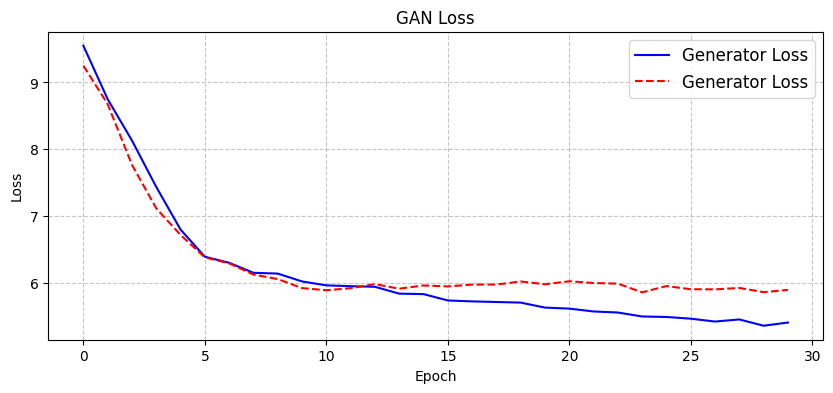

In [36]:
plt.figure(figsize=(10, 4))

plt.plot(history.history['g_loss_masked_unmasked'], label='Generator Loss', linestyle='-', color='b')
plt.plot(history.history['g_loss_unmasked_masked'], label='Generator Loss', linestyle='--', color='r')
plt.title('GAN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize='large')
plt.grid(True, linestyle='--', alpha=0.7)

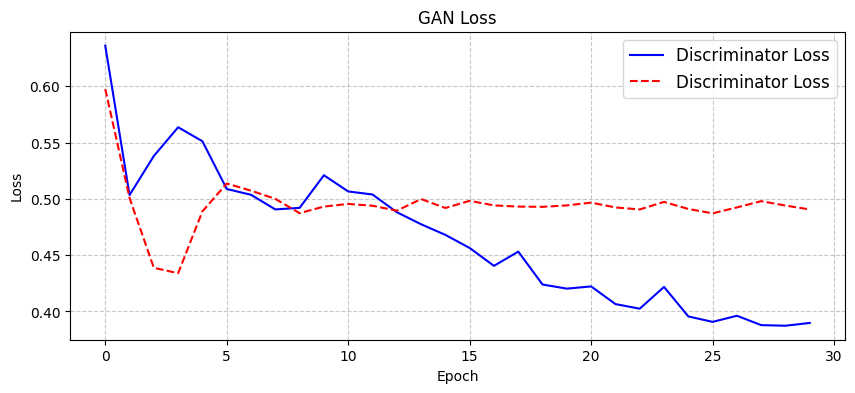

In [37]:
plt.figure(figsize=(10, 4))

plt.plot(history.history['d_loss_masked'], label='Discriminator Loss', linestyle='-', color='b')
plt.plot(history.history['d_loss_unmasked'], label='Discriminator Loss', linestyle='--', color='r')
plt.title('GAN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize='large')
plt.grid(True, linestyle='--', alpha=0.7)

In [52]:
from PIL import Image
import os

images_folder = "/content/generated"
gif_filename = "Masked_Unmasked.gif"

images = []
for filename in sorted(os.listdir(images_folder)):
  if filename.endswith(".png"):
    filepath = os.path.join(images_folder, filename)
    img = Image.open(filepath)
    images.append(img)

images[0].save(gif_filename, save_all=True,
              append_images=images[1:],
              duration=500,
              loop=0)

# Saving and Loading Model

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
cycle_gan.generator_masked_unmasked.save("Face_Masked_to_Unmasked")
loaded_model = tf.keras.models.load_model("Face_Masked_to_Unmasked")

1/1 [==============================] - 1s 930ms/step


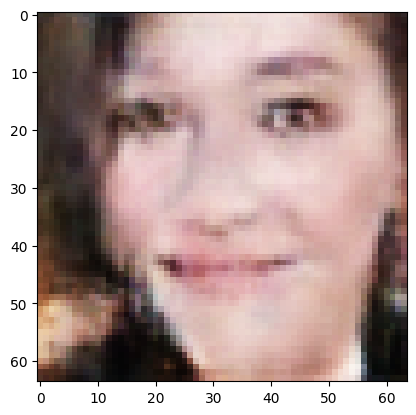

In [43]:
image_path = "/content/dataset/dataset/i00002.jpg"
image = tf.io.decode_png(tf.io.read_file(image_path), channels=3)
image = tf.image.resize(image, [64, 64])
image = tf.cast(image, tf.float32) /127.5 - 1.0
image = tf.expand_dims(image, axis=0)
output = cycle_gan.generator_masked_unmasked.predict(image)
plt.imshow((output[0]+1)/2)

# Hugging Face Model

In [44]:
! pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 5.2 MB/s eta 0:00:00


In [45]:
from huggingface_hub import notebook_login
notebook_login()

In [46]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = cycle_gan.generator_masked_unmasked, repo_id = "DriveMyScream/Face_obstruction_removal")

saved_model.pb:   0%|          | 0.00/654k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/61.5M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/118k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

'https://huggingface.co/DriveMyScream/Face_obstruction_removal/tree/main/'

In [47]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/Face_obstruction_removal")

config.json not found in HuggingFace Hub.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

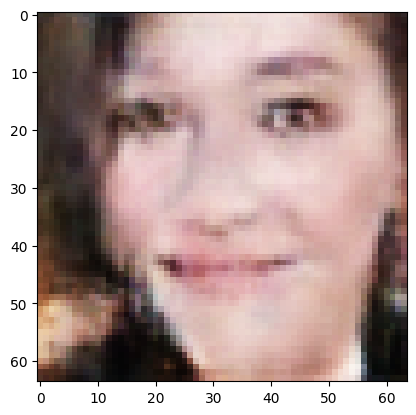

In [48]:
image_path = "/content/dataset/dataset/i00002.jpg"
image = tf.io.decode_png(tf.io.read_file(image_path), channels=3)
image = tf.image.resize(image, [64, 64])
image = tf.cast(image, tf.float32) /127.5 - 1.0
image = tf.expand_dims(image, axis=0)
output = loaded_model(image)
plt.imshow((output[0]+1)/2)

# Tensorflow Lite

In [49]:
converter = tf.lite.TFLiteConverter.from_keras_model(cycle_gan.generator_masked_unmasked)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Face_obstruction_removal.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

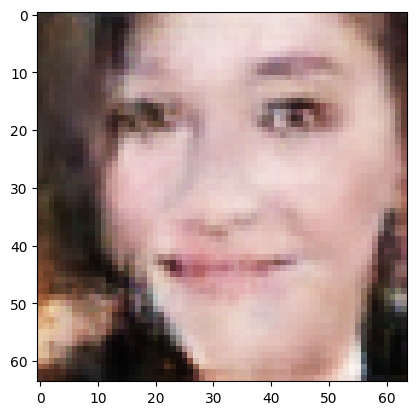

In [51]:
tflite_model_path = "/content/Face_obstruction_removal.tflite"

interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image_path = "/content/dataset/dataset/i00002.jpg"
image = tf.io.decode_png(tf.io.read_file(image_path), channels=3)
image = tf.image.resize(image, [64, 64])
image = tf.cast(image, tf.float32) / 127.5 - 1.0
image = tf.expand_dims(image, axis=0)

interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()
output_image = interpreter.get_tensor(output_details[0]['index'])

output_image = (output_image + 1) / 2
plt.imshow(output_image[0])
plt.show()